# Итоговая модель прогнозирования stock

In [1]:
sym = 'SBERP'

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset

import numpy as np
import pandas as pd
import pandas_ta as ta

import seaborn as sns
sns.set_style("darkgrid")

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab

import plotly.express as px
import plotly.graph_objects as go

import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import datetime
from datetime import datetime, date, timedelta
import time

import random
import math

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE 

'cpu'

In [4]:
# Sequence length of input
WINDOW_SIZE = 30
# Number of hidden layer neurons in LSTM
HIDDEN_SIZE = 128
# Number of LSTMs
NUM_L = 2
input_size = 12
output_size = 12

BATCH_SIZE = 128
EPOCHS = 10

method = 'GRU'
bidirectional = True

RANDOM_STATE = 42

In [5]:
data = pd.read_csv(f'{sym}_day.csv', index_col=0, parse_dates=True)
data

,TICKER,PER,TIME,OPEN,HIGH,LOW,CLOSE,VOL
DATE,,,,,,,,
2013-01-08,SBERP,D,0,68.99,70.78,68.72,70.38,17944900
2013-01-09,SBERP,D,0,70.36,71.30,70.12,70.69,15790900
2013-01-10,SBERP,D,0,70.87,71.00,70.50,70.90,12258200
2013-01-11,SBERP,D,0,70.91,71.67,70.72,71.32,15105700
2013-01-14,SBERP,D,0,71.67,72.70,71.65,72.47,18319300
...,...,...,...,...,...,...,...,...
2023-11-16,SBERP,D,0,281.09,282.40,278.56,278.91,2443680
2023-11-17,SBERP,D,0,278.90,281.78,278.00,280.79,2877840
2023-11-20,SBERP,D,0,280.35,282.99,280.07,282.27,2868670


In [6]:
# функция по созданию сгенерированных признаков
def make_features(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.isin([5,6])*1
    
    return data

In [7]:
data = make_features(data)
data

,TICKER,PER,TIME,OPEN,HIGH,LOW,CLOSE,VOL,year,month,day,dayofweek,is_weekend
DATE,,,,,,,,,,,,,
2013-01-08,SBERP,D,0,68.99,70.78,68.72,70.38,17944900,2013,1,8,1,0
2013-01-09,SBERP,D,0,70.36,71.30,70.12,70.69,15790900,2013,1,9,2,0
2013-01-10,SBERP,D,0,70.87,71.00,70.50,70.90,12258200,2013,1,10,3,0
2013-01-11,SBERP,D,0,70.91,71.67,70.72,71.32,15105700,2013,1,11,4,0
2013-01-14,SBERP,D,0,71.67,72.70,71.65,72.47,18319300,2013,1,14,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-16,SBERP,D,0,281.09,282.40,278.56,278.91,2443680,2023,11,16,3,0
2023-11-17,SBERP,D,0,278.90,281.78,278.00,280.79,2877840,2023,11,17,4,0
2023-11-20,SBERP,D,0,280.35,282.99,280.07,282.27,2868670,2023,11,20,0,0


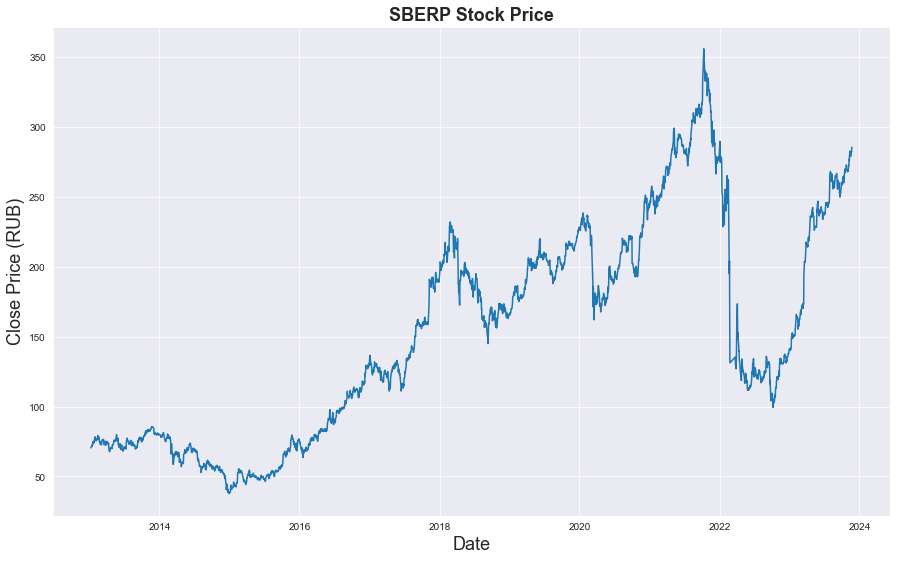

In [8]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['CLOSE']])
plt.title(f"{sym} Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (RUB)',fontsize=18)
plt.show()

In [9]:
# Adding indicators
data['RSI'] = ta.rsi(data.CLOSE, length=15)
data['EMAF'] = ta.ema(data.CLOSE, length=20)
data['EMAM'] = ta.ema(data.CLOSE, length=100)
data['EMAS'] = ta.ema(data.CLOSE, length=150)
data['VWAP'] = ta.vwap(data.HIGH, data.LOW, data.CLOSE, data.VOL, anchor = "D")
data

,TICKER,PER,TIME,OPEN,HIGH,LOW,CLOSE,VOL,year,month,day,dayofweek,is_weekend,RSI,EMAF,EMAM,EMAS,VWAP
DATE,,,,,,,,,,,,,,,,,,
2013-01-08,SBERP,D,0,68.99,70.78,68.72,70.38,17944900,2013,1,8,1,0,NaN,NaN,NaN,NaN,69.960000
2013-01-09,SBERP,D,0,70.36,71.30,70.12,70.69,15790900,2013,1,9,2,0,NaN,NaN,NaN,NaN,70.703333
2013-01-10,SBERP,D,0,70.87,71.00,70.50,70.90,12258200,2013,1,10,3,0,NaN,NaN,NaN,NaN,70.800000
2013-01-11,SBERP,D,0,70.91,71.67,70.72,71.32,15105700,2013,1,11,4,0,NaN,NaN,NaN,NaN,71.236667
2013-01-14,SBERP,D,0,71.67,72.70,71.65,72.47,18319300,2013,1,14,0,0,NaN,NaN,NaN,NaN,72.273333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-16,SBERP,D,0,281.09,282.40,278.56,278.91,2443680,2023,11,16,3,0,62.857400,273.862406,257.536901,246.357758,279.956667
2023-11-17,SBERP,D,0,278.90,281.78,278.00,280.79,2877840,2023,11,17,4,0,65.143618,274.522177,257.997358,246.813814,280.190000
2023-11-20,SBERP,D,0,280.35,282.99,280.07,282.27,2868670,2023,11,20,0,0,66.863954,275.260065,258.478005,247.283433,281.776667


In [10]:
data['Target'] = data['CLOSE'] - data.OPEN
data['Target'] = data['Target'].shift(-1)
# data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]
# data['TargetNextClose'] = data['CLOSE'].shift(-1)
pd.set_option('display.max_columns', None)
data

,TICKER,PER,TIME,OPEN,HIGH,LOW,CLOSE,VOL,year,month,day,dayofweek,is_weekend,RSI,EMAF,EMAM,EMAS,VWAP,Target
DATE,,,,,,,,,,,,,,,,,,,
2013-01-08,SBERP,D,0,68.99,70.78,68.72,70.38,17944900,2013,1,8,1,0,NaN,NaN,NaN,NaN,69.960000,0.33
2013-01-09,SBERP,D,0,70.36,71.30,70.12,70.69,15790900,2013,1,9,2,0,NaN,NaN,NaN,NaN,70.703333,0.03
2013-01-10,SBERP,D,0,70.87,71.00,70.50,70.90,12258200,2013,1,10,3,0,NaN,NaN,NaN,NaN,70.800000,0.41
2013-01-11,SBERP,D,0,70.91,71.67,70.72,71.32,15105700,2013,1,11,4,0,NaN,NaN,NaN,NaN,71.236667,0.80
2013-01-14,SBERP,D,0,71.67,72.70,71.65,72.47,18319300,2013,1,14,0,0,NaN,NaN,NaN,NaN,72.273333,-0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-16,SBERP,D,0,281.09,282.40,278.56,278.91,2443680,2023,11,16,3,0,62.857400,273.862406,257.536901,246.357758,279.956667,1.89
2023-11-17,SBERP,D,0,278.90,281.78,278.00,280.79,2877840,2023,11,17,4,0,65.143618,274.522177,257.997358,246.813814,280.190000,1.92
2023-11-20,SBERP,D,0,280.35,282.99,280.07,282.27,2868670,2023,11,20,0,0,66.863954,275.260065,258.478005,247.283433,281.776667,0.65


In [11]:
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['VOL', 'TICKER', 'PER', 'TIME' ], axis=1, inplace=True)
data_set = data.iloc[:, 0:13]
pd.set_option('display.max_columns', None)
data_set

,DATE,OPEN,HIGH,LOW,CLOSE,year,month,day,dayofweek,is_weekend,RSI,EMAF,EMAM
0,2013-08-09,72.50,73.20,72.02,73.12,2013,8,9,4,0,48.571120,73.644141,73.296521
1,2013-08-12,73.07,73.50,72.22,73.15,2013,8,12,0,0,48.697331,73.597080,73.293619
2,2013-08-13,73.15,74.37,72.93,74.15,2013,8,13,1,0,52.831464,73.649739,73.310577
3,2013-08-14,74.24,74.90,74.01,74.59,2013,8,14,2,0,54.557778,73.739288,73.335912
4,2013-08-15,74.47,74.57,72.40,72.51,2013,8,15,3,0,46.025916,73.622213,73.319558
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,2023-11-15,279.29,282.78,277.33,281.49,2023,11,15,2,0,68.622410,273.331080,257.105121
2572,2023-11-16,281.09,282.40,278.56,278.91,2023,11,16,3,0,62.857400,273.862406,257.536901
2573,2023-11-17,278.90,281.78,278.00,280.79,2023,11,17,4,0,65.143618,274.522177,257.997358
2574,2023-11-20,280.35,282.99,280.07,282.27,2023,11,20,0,0,66.863954,275.260065,258.478005


In [12]:
sc = MinMaxScaler(feature_range=(-1, 1))
data_scaled = sc.fit_transform(data_set.iloc[:, 1:])
data_scaled

array([[-0.77663122, -0.78389591, -0.77106723, ..., -0.10387109,
        -0.78529291, -0.81564013],
       [-0.77304474, -0.78201018, -0.76977675, ..., -0.10041403,
        -0.7856158 , -0.81566219],
       [-0.77254137, -0.77654158, -0.76519551, ...,  0.01282439,
        -0.7852545 , -0.81553321],
       ...,
       [ 0.52205373,  0.52718587,  0.55800748, ...,  0.35006784,
         0.59295417,  0.58922248],
       [ 0.53117725,  0.53479163,  0.57136405, ...,  0.39718973,
         0.59801691,  0.59287835],
       [ 0.54048952,  0.53340876,  0.57136405, ...,  0.40394924,
         0.6027347 ,  0.59649345]])

In [13]:
data_scaled.shape

(2576, 12)

In [14]:
data_time = data_set['DATE'][WINDOW_SIZE:]

In [15]:
class SeriesDataset(Dataset):
                            def __init__(self, data, window_size):
                                    self.data = data  
                                    self.window_size = window_size
                    
                                    self.y = []
                                    self.sequence = []
                                
                                    for j in range(self.data.shape[1]):
                                                    self.sequence.append([])
                                                    self.y.append([])
                                            
                                                    for i in range(self.data.shape[0] - self.window_size):
                                                            self.sequence[j].append(self.data[i : i + self.window_size, j])
                                                            self.y[j].append(self.data[i + 1 : i + self.window_size + 1, j])
                                  
                                    
                                    
                                    
                                    self.sequence = np.array(np.moveaxis(self.sequence, [0], [2]))
                                    self.y = np.array(np.moveaxis(self.y, [0], [2]))

                                    

                        
                            def __len__(self):
                                                return len(self.data) - self.window_size

                            def __getitem__(self, idx):
                                                sequence = self.sequence[idx]
                                                label = self.y[idx]
                                                pred = self.y[idx][-1, 3]
                                                                                                                                         
                                                sequence = torch.tensor(sequence).float()
                                                label = torch.tensor(label).float()
                                                pred = torch.tensor(pred).float()
                     
                                        
                                                return sequence, label, pred

In [16]:
dataset = SeriesDataset(data_scaled, WINDOW_SIZE)

In [17]:
dataset.__getitem__(1)

(tensor([[-0.7730, -0.7820, -0.7698, -0.7773, -1.0000,  0.2727, -0.2667, -1.0000,
          -1.0000, -0.1004, -0.7856, -0.8157],
         [-0.7725, -0.7765, -0.7652, -0.7710, -1.0000,  0.2727, -0.2000, -0.6000,
          -1.0000,  0.0128, -0.7853, -0.8155],
         [-0.7657, -0.7732, -0.7582, -0.7682, -1.0000,  0.2727, -0.1333, -0.2000,
          -1.0000,  0.0601, -0.7846, -0.8153],
         [-0.7642, -0.7753, -0.7686, -0.7813, -1.0000,  0.2727, -0.0667,  0.2000,
          -1.0000, -0.1736, -0.7854, -0.8155],
         [-0.7766, -0.7860, -0.7744, -0.7844, -1.0000,  0.2727,  0.0000,  0.6000,
          -1.0000, -0.2215, -0.7865, -0.8157],
         [-0.7810, -0.7833, -0.7728, -0.7791, -1.0000,  0.2727,  0.2000, -1.0000,
          -1.0000, -0.1219, -0.7869, -0.8157],
         [-0.7780, -0.7884, -0.7751, -0.7858, -1.0000,  0.2727,  0.2667, -0.6000,
          -1.0000, -0.2292, -0.7879, -0.8160],
         [-0.7810, -0.7884, -0.7777, -0.7866, -1.0000,  0.2727,  0.3333, -0.2000,
          -1.00

In [18]:
dataset. __len__()

2546

In [19]:
dataset.__getitem__(1)[0].size()

torch.Size([30, 12])

In [20]:
dataset.__getitem__(1)[1].size()

torch.Size([30, 12])

In [21]:
dataset.__getitem__(1)[2].size()

torch.Size([])

In [22]:
splitlimit1 = int(len(dataset) * 0.8)
train_dataset =  Subset(dataset, np.arange(splitlimit1))
t_dataset =  Subset(dataset, np.arange(splitlimit1, len(dataset)))
splitlimit2 = int(len(t_dataset) * 0.5)
val_dataset =  Subset(t_dataset, np.arange(splitlimit2))
test_dataset =  Subset(t_dataset, np.arange(splitlimit2, len(t_dataset)))

In [23]:
 len(dataset), len(train_dataset), len(test_dataset), len(val_dataset), len(val_dataset)+len(test_dataset)+len(train_dataset)

(2546, 2036, 255, 255, 2546)

In [24]:
time_train = data_time[ : len(train_dataset)]
time_val = data_time[len(train_dataset) : len(train_dataset) + len(val_dataset)]
time_test = data_time[len(train_dataset) + len(val_dataset) : ]

In [25]:
len(time_train)+len(time_val)+len(time_test)

2546

In [26]:
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
train_dataloader1 = DataLoader(train_dataset, batch_size = 1)
val_dataloader = DataLoader(val_dataset, batch_size = 1)
test_dataloader = DataLoader(test_dataset, batch_size = 1)

In [27]:
class My_Model_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=False, method='GRU', dropout_p = 0.2):
        super(My_Model_GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size * 2 if bidirectional else hidden_size
        self.hidden_var = hidden_size if bidirectional else hidden_size // 2
        self.bidirectional = bidirectional
        self.output_size = output_size
        self.num_layers = num_layers
        self.relu = nn.ReLU()
        self.do = nn.Dropout(dropout_p)
        self.method = method
        if self.method == 'GRU':
                self.net = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                                                num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        elif self.method == 'LSTM':
                self.net = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                                num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.linear1 = nn.Linear(self.hidden_size, self.hidden_var)
        self.linear2 = nn.Linear(self.hidden_var, output_size)
         
        
    def forward(self, input, future=0, y=None):

        ht, ct = self.net(input)
        output = self.linear1(self.do(ht))
        output = self.relu(output)
        outputs = self.linear2(output)
        teacher = outputs
        
        if future != 0:
            out = []
            c = 0
            for i in range(future):
                if y is not None and random.random() > 0.5:
                    c += 1
                    outputs = y[:, [i], :]  # teacher forcing
                ht, ct = self.net(outputs, ct)
                output = self.linear1(self.do(ht))
                output = self.relu(output)
                output = self.linear2(output)
                out += [output[:,-1,:]]
            
            out = torch.stack(out, 1).squeeze(2)
            
            if c > 0 : outputs = torch.cat((teacher, out), 1) 
            else: outputs = torch.cat((outputs, out), 1) 
      
        return outputs, outputs[:,-1,3]

In [28]:
model_my = My_Model_GRU(input_size, HIDDEN_SIZE, NUM_L, output_size, bidirectional=bidirectional, method = method)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_my.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [29]:
X,y,p = next(iter(train_dataloader))
output1, output2 = model_my(X)
print(X.size())
print(y.size())
print(p.size())
print(output1.size())
print(output2.size())
# print(output.unsqueeze(0).size())
# loss = criterion(output, y)

torch.Size([128, 30, 12])
torch.Size([128, 30, 12])
torch.Size([128])
torch.Size([128, 30, 12])
torch.Size([128])


In [30]:
class Optimization:
    """ A helper class to train, test and diagnose the GRU"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    def train(
        self,
        dataloader_train,
        n_epochs,
        dataloader_val = None,
        do_teacher_forcing=None,
    
    ):
        for epoch in range(n_epochs):
            start_time = time.time()
            train_loss = 0
            loop = tqdm(dataloader_train, desc='Train', colour='green')
            for b, batch in enumerate(loop):
                x_batch, y_batch, y_b = batch[0], batch[1], batch[2]
                y_pr, y_pred = self._predict(x_batch, y_batch, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pr, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= (b+1)
            self.train_losses.append(train_loss)

            self._validation(dataloader_val)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )
            
            torch.save(self.model.state_dict(), f'./chkpt_mymodel_{epoch+1}.pth')
    
    def _predict(self, x_batch, y_batch, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(y_batch.shape[1]) / 2)
            limit = x_batch.size(1) - future
            y_pr, y_pred = self.model(x_batch[:, :limit, :], future=future, y=y_batch[:, limit:, :])
        else:
            future = 0
            y_pr, y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pr, y_pred
    
    def _validation(self, dataloader_val):
        if dataloader_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            loop = tqdm(dataloader_val, desc='Val', colour='green')
            for b, batch in enumerate(loop):
                x_batch, y_batch, y_b = batch[0], batch[1], batch[2]
                y_pr, y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pr, y_batch)
                val_loss += loss.item()
            val_loss /= b+1
            self.val_losses.append(val_loss)

    def evaluate(self, dataloader_test, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            loop = tqdm(dataloader_test, desc='Test', colour='green')
            for b, batch in enumerate(loop):
                x_batch, y_batch, y_b = batch[0], batch[1], batch[2]
                y_pr, y_pred = self.model(x_batch, future=future)
                y_pr = (
                    y_pr[:, -y_batch.shape[1] :, :] if y_pr.shape[1] > y_batch.shape[1] else y_pr
                )
                loss = self.loss_fn(y_pr, y_batch)
                test_loss += loss.item()            
                if x_batch.shape[0] > 1:
                            actual += torch.squeeze(y_batch[:, -1, :]).data.cpu().numpy().tolist()

                            predicted += torch.squeeze(y_pr[:, -1, :]).data.cpu().numpy().tolist()

                else:
                            actual.append(torch.squeeze(y_batch[:, -1, :]).data.cpu().numpy().tolist())
                            predicted.append(torch.squeeze(y_pr[:, -1, :]).data.cpu().numpy().tolist())


            
            test_loss /= (b+1)
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [31]:
optimization_1 = Optimization(model_my, criterion, optimizer, scheduler)

In [32]:
optimization_1.train(train_dataloader, n_epochs = EPOCHS, dataloader_val = val_dataloader, do_teacher_forcing=False)

Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 67.84it/s]


Epoch 1 Train loss: 0.26. Validation loss: 0.15. Avg future: 0.00. Elapsed time: 15.40s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 66.35it/s]


Epoch 2 Train loss: 0.05. Validation loss: 0.10. Avg future: 0.00. Elapsed time: 15.30s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 69.05it/s]


Epoch 3 Train loss: 0.03. Validation loss: 0.07. Avg future: 0.00. Elapsed time: 15.57s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 64.64it/s]


Epoch 4 Train loss: 0.01. Validation loss: 0.05. Avg future: 0.00. Elapsed time: 15.25s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 64.15it/s]


Epoch 5 Train loss: 0.01. Validation loss: 0.04. Avg future: 0.00. Elapsed time: 15.50s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 66.03it/s]


Epoch 6 Train loss: 0.01. Validation loss: 0.04. Avg future: 0.00. Elapsed time: 15.25s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 67.57it/s]


Epoch 7 Train loss: 0.01. Validation loss: 0.04. Avg future: 0.00. Elapsed time: 15.18s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 66.30it/s]


Epoch 8 Train loss: 0.01. Validation loss: 0.04. Avg future: 0.00. Elapsed time: 15.25s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 66.48it/s]


Epoch 9 Train loss: 0.01. Validation loss: 0.04. Avg future: 0.00. Elapsed time: 15.21s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 66.89it/s]

Epoch 10 Train loss: 0.01. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 15.15s.


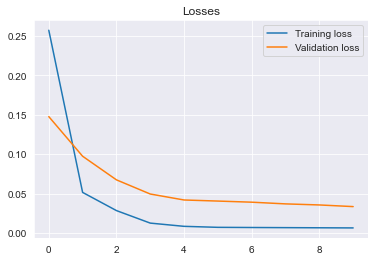

In [33]:
optimization_1.plot_losses()

In [34]:
def to_dataframe(scalar, actual, predicted, columns, future = 0):
    y = pd.DataFrame(scalar.inverse_transform(np.array(actual)), columns = columns)
    y_pred = pd.DataFrame(scalar.inverse_transform(np.array(predicted)), columns = columns)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    
    y['Target'] = y['CLOSE'] - y.OPEN
    y['TargetClass'] = [1 if y.Target[i] > 0 else 0 for i in range(len(y))]
    
    y_pred['Target'] = y_pred['CLOSE'] - y_pred['CLOSE'].shift()
    y_pred['TargetClass'] = [1 if y_pred.Target[i] > 0 else 0 for i in range(len(y_pred))]
    
    if future == 0:
                   f1 = metrics.f1_score(y['TargetClass'], y_pred['TargetClass'])
                   acc = metrics.accuracy_score(y['TargetClass'], y_pred['TargetClass'])
                   recall = metrics.precision_score(y['TargetClass'], y_pred['TargetClass'])
    else: 
                   f1 = metrics.f1_score(y_pred['TargetClass'][future: ], y_pred['TargetClass'][:- future])
                   acc = metrics.accuracy_score(y_pred['TargetClass'][future: ], y_pred['TargetClass'][:- future])
                   recall = metrics.precision_score(y_pred['TargetClass'][future: ], y_pred['TargetClass'][:- future])
            
    
    error = {'MSE': mse,'RMSE': rmse,'MAE': mae, 'f1': f1, 'acc': acc, 'recall': recall}
    print('MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}, f1: {:.4f}, acc: {:.4f}, recall: {:.4f}'.format(mse, rmse, mae, f1, acc, recall))
    
    return y, y_pred, error

In [35]:
future1 = 0

In [36]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(test_dataloader, future = future1)
df_actual_1, df_predicted_1, error1 = to_dataframe(sc, actual_1, predicted_1, data_set.columns[1:], future = future1) 

Test: 100%|██████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 67.42it/s]

MSE: 96.5282, RMSE: 9.8249, MAE: 6.6161, f1: 0.4962, acc: 0.4824, recall: 0.5078


In [37]:
if future1 == 0:
    res = pd.DataFrame(df_predicted_1['CLOSE'])
    res = res.set_index(time_test)
else: 
    f = pd.DataFrame(df_actual_1['CLOSE'])
    f = f.set_index(time_test)
    f1 = pd.DataFrame(df_predicted_1['CLOSE'][: - future1])
    f1 = f1.set_index(f.index[future1:])
    f2 = pd.DataFrame(df_predicted_1['CLOSE'][- future1: ])
    index2  = pd.date_range(time_test.iloc[-1:].values[0], freq="D", periods=future1 +1)
    f2 = f2.set_index(index2[1:])
    res = pd.concat([f1, f2], axis=0)

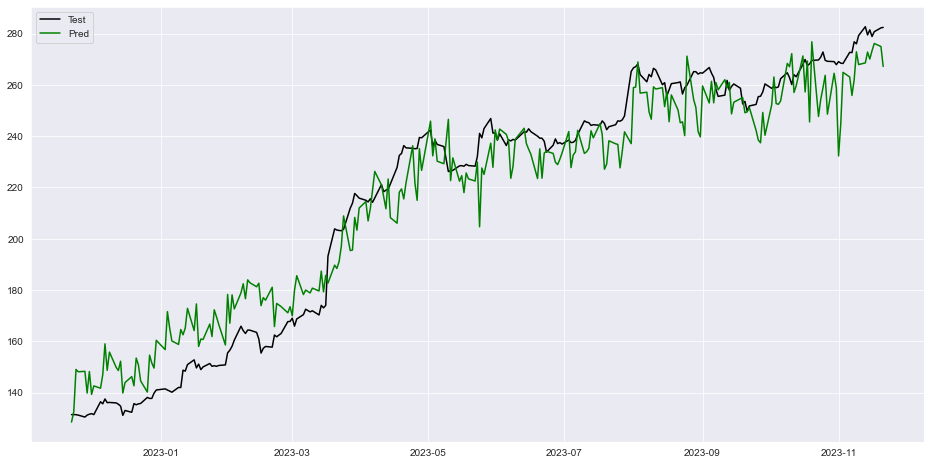

Test loss1 0.0341


In [38]:
plt.figure(figsize=(16,8))
plt.plot(time_test, df_actual_1['CLOSE'], color='black', label='Test')
plt.plot(res, color='green', label='Pred')
plt.legend()
plt.show()
print("Test loss1 %.4f" % test_loss_1)

In [39]:
future1 = 5

In [40]:
actual_1, predicted_1, test_loss_15 = optimization_1.evaluate(test_dataloader, future = future1)
df_actual_1, df_predicted_1, error12 = to_dataframe(sc, actual_1, predicted_1, data_set.columns[1:], future = future1) 

Test: 100%|██████████████████████████████████████████████████████████████████████████| 255/255 [00:20<00:00, 12.16it/s]

MSE: 115.4697, RMSE: 10.7457, MAE: 7.6023, f1: 0.4937, acc: 0.5160, recall: 0.4958


In [41]:
if future1 == 0:
    res = pd.DataFrame(df_predicted_1['CLOSE'])
    res = res.set_index(time_test)
else: 
    f = pd.DataFrame(df_actual_1['CLOSE'])
    f = f.set_index(time_test)
    f1 = pd.DataFrame(df_predicted_1['CLOSE'][: - future1])
    f1 = f1.set_index(f.index[future1:])
    f2 = pd.DataFrame(df_predicted_1['CLOSE'][- future1: ])
    index2  = pd.date_range(time_test.iloc[-1:].values[0], freq="D", periods=future1 +1)
    f2 = f2.set_index(index2[1:])
    res = pd.concat([f1, f2], axis=0)

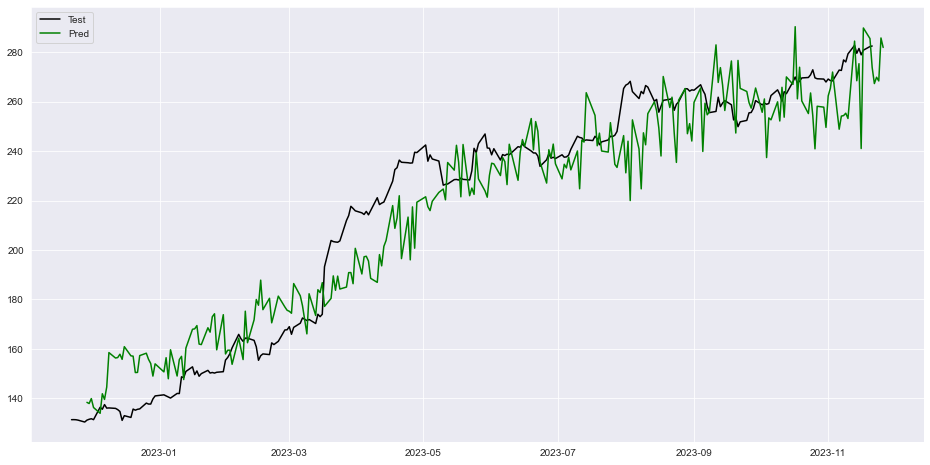

Test loss2 0.1120


In [42]:
plt.figure(figsize=(16,8))
plt.plot(time_test, df_actual_1['CLOSE'], color='black', label='Test')
plt.plot(res, color='green', label='Pred')
plt.legend()
plt.show()
print("Test loss2 %.4f" % test_loss_15)

Test: 100%|██████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 69.65it/s]


MSE: 314.8814, RMSE: 17.7449, MAE: 11.8157, f1: 0.4870, acc: 0.5373, recall: 0.4828


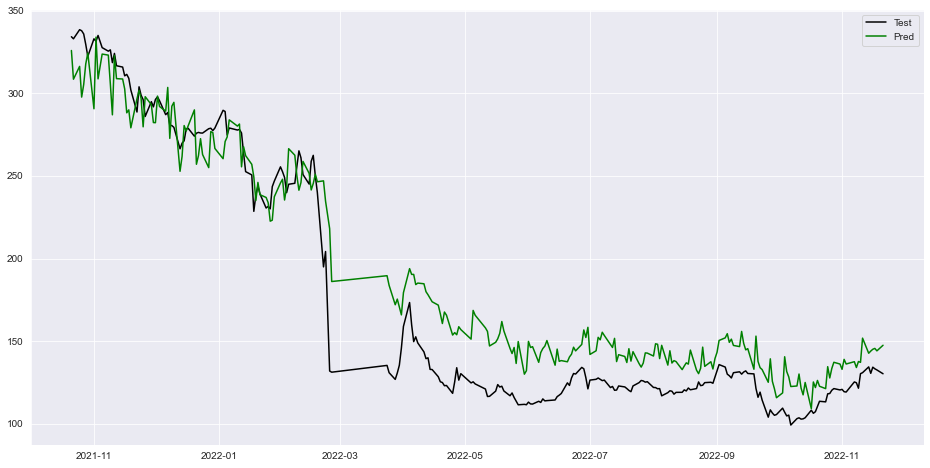

Val loss 0.0334


In [43]:
actual_2, predicted_2, val_loss_2 = optimization_1.evaluate(val_dataloader, future=0)
df_actual_2, df_predicted_2, error2 = to_dataframe(sc, actual_2, predicted_2, data_set.columns[1:]) 
plt.figure(figsize=(16,8))
plt.plot(time_val, df_actual_2['CLOSE'], color='black', label='Test')
plt.plot(time_val, df_predicted_2['CLOSE'], color='green', label='Pred')
plt.legend()
plt.show()
print("Val loss %.4f" % val_loss_2)

Test: 100%|████████████████████████████████████████████████████████████████████████| 2036/2036 [00:30<00:00, 66.52it/s]


MSE: 42.3571, RMSE: 6.5082, MAE: 4.1218, f1: 0.5131, acc: 0.5079, recall: 0.5106


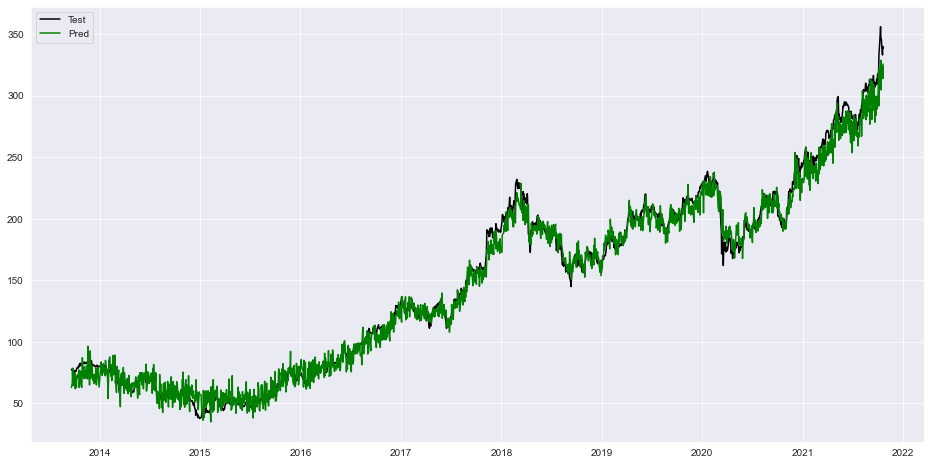

Train loss 0.0063


In [44]:
actual_3, predicted_3, train_loss_3 = optimization_1.evaluate(train_dataloader1, future=0)
df_actual_3, df_predicted_3, error3 = to_dataframe(sc, actual_3, predicted_3, data_set.columns[1:]) 
plt.figure(figsize=(16,8))
plt.plot(time_train, df_actual_3['CLOSE'], color='black', label='Test')
plt.plot(time_train, df_predicted_3['CLOSE'], color='green', label='Pred')
plt.legend()
plt.show()
print("Train loss %.4f" % train_loss_3)

In [45]:
def generate_sequence(scaler, model, x_sample, future):
    """ Generate future values for x_sample with the model """
    y_pred_tensor, _ = model(x_sample, future=future)
    y_pred_tensor = y_pred_tensor.squeeze(0).detach().numpy()
    y_pred_tensor = pd.DataFrame(scaler.inverse_transform(y_pred_tensor))   
    y_pred = y_pred_tensor[3]
    
    return y_pred

In [46]:
future=200

In [47]:
x_sample = dataset[-(future + WINDOW_SIZE)][0]
x_sample = x_sample.unsqueeze(0)
x_sample1 = x_sample

In [48]:
index = data_time.iloc[-(future + WINDOW_SIZE):].values

In [49]:
y_sample = dataset[-(future + WINDOW_SIZE):][1][:,-1,:]
y_sample = pd.DataFrame(sc.inverse_transform(y_sample)) 
y_sample = y_sample[3]
y_sample = pd.DataFrame(y_sample)
y_sample = y_sample.set_index(index)
y_sample['Target'] = y_sample[3] - y_sample[3].shift()
y_sample['TargetClass'] = [1 if y_sample.Target[i] > 0 else 0 for i in range(len(y_sample))]

In [50]:
y_pred = generate_sequence(sc, optimization_1.model, x_sample1, future=future)
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.set_index(index)
y_pred['Target'] = y_pred[3] - y_pred[3].shift()
y_pred['TargetClass'] = [1 if y_pred.Target[i] > 0 else 0 for i in range(len(y_pred))]

In [51]:
mse = mean_squared_error(y_sample[3], y_pred[3])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_sample[3], y_pred[3])
f1 = metrics.f1_score(y_sample['TargetClass'][WINDOW_SIZE:], y_pred['TargetClass'][WINDOW_SIZE:])
acc = metrics.accuracy_score(y_sample['TargetClass'][WINDOW_SIZE:], y_pred['TargetClass'][WINDOW_SIZE:])
recall = metrics.precision_score(y_sample['TargetClass'][WINDOW_SIZE:], y_pred['TargetClass'][WINDOW_SIZE:])
error_gen1 = {'MSE': mse,'RMSE': rmse,'MAE': mae, 'f1': f1, 'acc': acc, 'recall': recall}
print('MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}, f1: {:.4f}, acc: {:.4f}, recall: {:.4f}'.format(mse, rmse, mae, f1, acc, recall))

MSE: 6866.1310, RMSE: 82.8621, MAE: 72.7771, f1: 0.4880, acc: 0.4650, recall: 0.5204


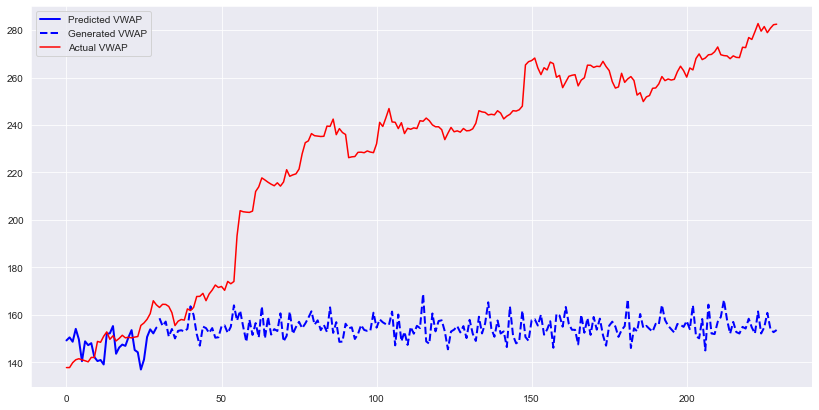

In [52]:
plt.figure(figsize=(14, 7))
plt.plot(range(WINDOW_SIZE), y_pred[3][:WINDOW_SIZE], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(WINDOW_SIZE, future + WINDOW_SIZE), y_pred[3][WINDOW_SIZE:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, future + WINDOW_SIZE), y_sample[3][:future + WINDOW_SIZE], color="red", label="Actual VWAP")
plt.legend()

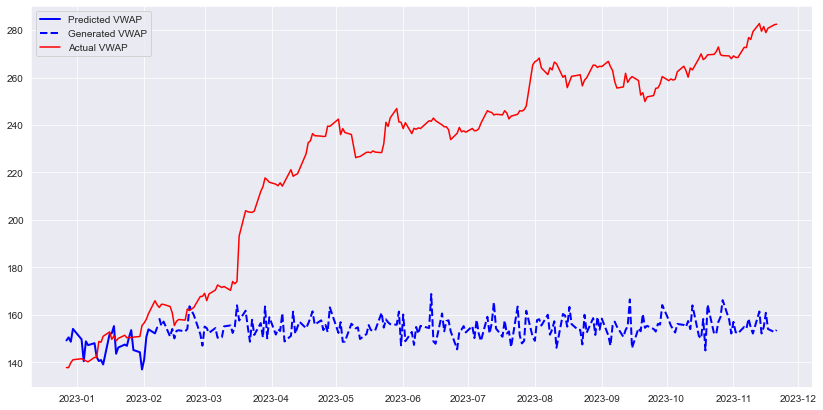

In [53]:
plt.figure(figsize=(14, 7))
plt.plot(y_pred[3][:WINDOW_SIZE], color="blue", lw=2, label="Predicted VWAP")
plt.plot(y_pred[3][WINDOW_SIZE:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(y_sample[3][:future + WINDOW_SIZE], color="red", label="Actual VWAP")
plt.legend()

In [54]:
model_my2 = My_Model_GRU(input_size, HIDDEN_SIZE, NUM_L, output_size, bidirectional=bidirectional, method=method)
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model_my2.parameters(), lr=0.01)
scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=5, gamma=0.1)

In [55]:
optimization_2 = Optimization(model_my2, criterion2, optimizer2, scheduler2)

In [56]:
optimization_2.train(train_dataloader, n_epochs = EPOCHS, dataloader_val = val_dataloader, do_teacher_forcing=True)

Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 68.26it/s]


Epoch 1 Train loss: 0.31. Validation loss: 0.18. Avg future: 6.88. Elapsed time: 21.71s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:04<00:00, 63.21it/s]


Epoch 2 Train loss: 0.06. Validation loss: 0.11. Avg future: 7.66. Elapsed time: 25.08s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 67.19it/s]


Epoch 3 Train loss: 0.04. Validation loss: 0.08. Avg future: 7.52. Elapsed time: 23.22s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 66.17it/s]


Epoch 4 Train loss: 0.03. Validation loss: 0.07. Avg future: 7.47. Elapsed time: 22.88s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 65.17it/s]


Epoch 5 Train loss: 0.02. Validation loss: 0.06. Avg future: 7.62. Elapsed time: 27.42s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 67.12it/s]


Epoch 6 Train loss: 0.02. Validation loss: 0.06. Avg future: 7.71. Elapsed time: 22.34s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 65.00it/s]


Epoch 7 Train loss: 0.02. Validation loss: 0.06. Avg future: 7.54. Elapsed time: 24.66s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 69.13it/s]


Epoch 8 Train loss: 0.02. Validation loss: 0.05. Avg future: 7.62. Elapsed time: 19.72s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 65.62it/s]


Epoch 9 Train loss: 0.01. Validation loss: 0.05. Avg future: 7.40. Elapsed time: 22.72s.


Val: 100%|███████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 64.62it/s]

Epoch 10 Train loss: 0.02. Validation loss: 0.05. Avg future: 7.46. Elapsed time: 22.24s.


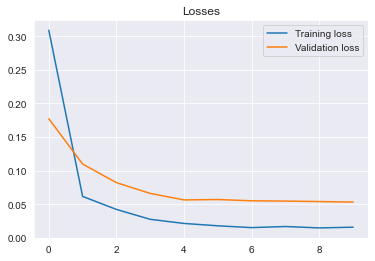

In [57]:
optimization_2.plot_losses()

In [58]:
future1 = 0

In [59]:
actual_11, predicted_11, test_loss_11 = optimization_2.evaluate(test_dataloader, future=future1)
df_actual_11, df_predicted_11, error11 = to_dataframe(sc, actual_11, predicted_11, data_set.columns[1:], future=future1) 

Test: 100%|██████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 68.68it/s]

MSE: 153.9559, RMSE: 12.4079, MAE: 8.0114, f1: 0.4361, acc: 0.4118, recall: 0.4394


In [60]:
if future1 == 0:
    res = pd.DataFrame(df_predicted_11['CLOSE'])
    res = res.set_index(time_test)
else: 
    f = pd.DataFrame(df_actual_11['CLOSE'])
    f = f.set_index(time_test)
    f1 = pd.DataFrame(df_predicted_11['CLOSE'][: - future1])
    f1 = f1.set_index(f.index[future1:])
    f2 = pd.DataFrame(df_predicted_11['CLOSE'][- future1: ])
    index2  = pd.date_range(time_test.iloc[-1:].values[0], freq="D", periods=future1 +1)
    f2 = f2.set_index(index2[1:])
    res = pd.concat([f1, f2], axis=0)

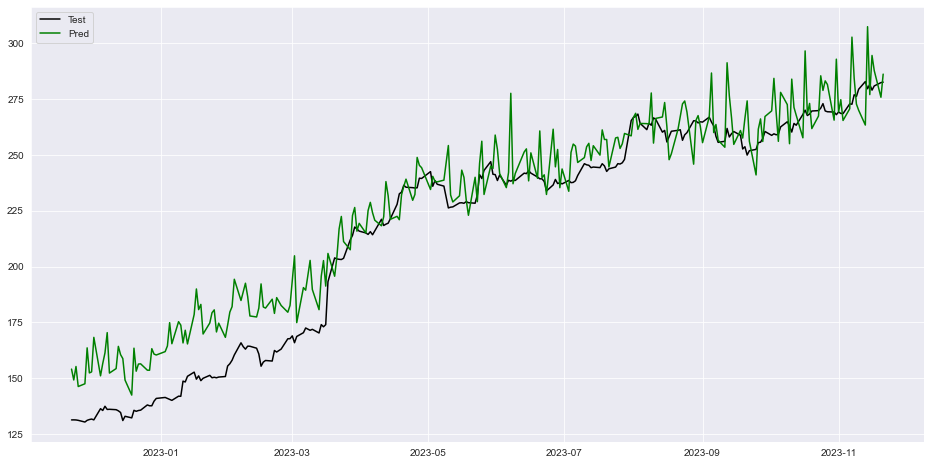

Test1 loss1 0.0475


In [61]:
plt.figure(figsize=(16,8))
plt.plot(time_test, df_actual_11['CLOSE'], color='black', label='Test')
plt.plot(res, color='green', label='Pred')
plt.legend()
plt.show()
print("Test1 loss1 %.4f" % test_loss_11)

In [62]:
future1 = 5

In [63]:
actual_11, predicted_11, test_loss_115 = optimization_2.evaluate(test_dataloader, future=future1)
df_actual_11, df_predicted_11, error112 = to_dataframe(sc, actual_11, predicted_11, data_set.columns[1:], future=future1) 

Test: 100%|██████████████████████████████████████████████████████████████████████████| 255/255 [00:22<00:00, 11.49it/s]

MSE: 160.1702, RMSE: 12.6558, MAE: 8.6179, f1: 0.6000, acc: 0.5840, recall: 0.5954


In [64]:
if future1 == 0:
    res = pd.DataFrame(df_predicted_11['CLOSE'])
    res = res.set_index(time_test)
else: 
    f = pd.DataFrame(df_actual_11['CLOSE'])
    f = f.set_index(time_test)
    f1 = pd.DataFrame(df_predicted_11['CLOSE'][: - future1])
    f1 = f1.set_index(f.index[future1:])
    f2 = pd.DataFrame(df_predicted_11['CLOSE'][- future1: ])
    index2  = pd.date_range(time_test.iloc[-1:].values[0], freq="D", periods=future1 +1)
    f2 = f2.set_index(index2[1:])
    res = pd.concat([f1, f2], axis=0)

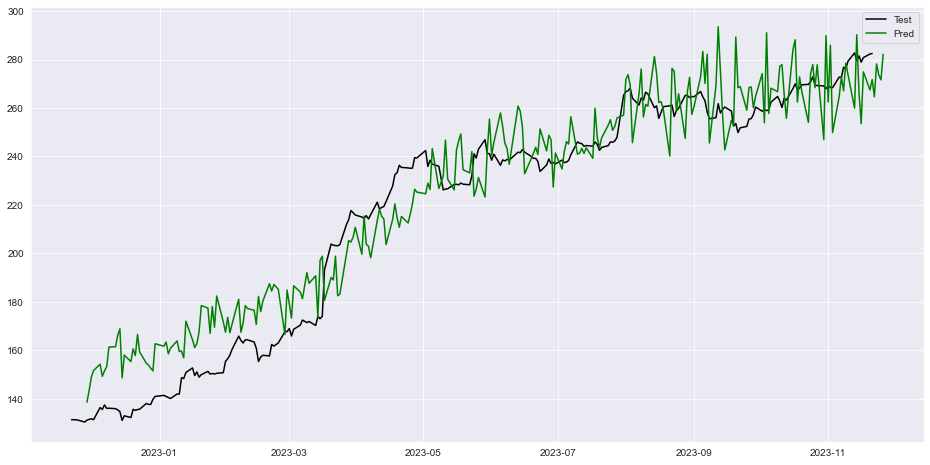

Test1 loss2 0.1139


In [65]:
plt.figure(figsize=(16,8))
plt.plot(time_test, df_actual_11['CLOSE'], color='black', label='Test')
plt.plot(res, color='green', label='Pred')
plt.legend()
plt.show()
print("Test1 loss2 %.4f" % test_loss_115)

Test: 100%|██████████████████████████████████████████████████████████████████████████| 255/255 [00:03<00:00, 66.44it/s]


MSE: 442.8593, RMSE: 21.0442, MAE: 14.0257, f1: 0.4661, acc: 0.5059, recall: 0.4508


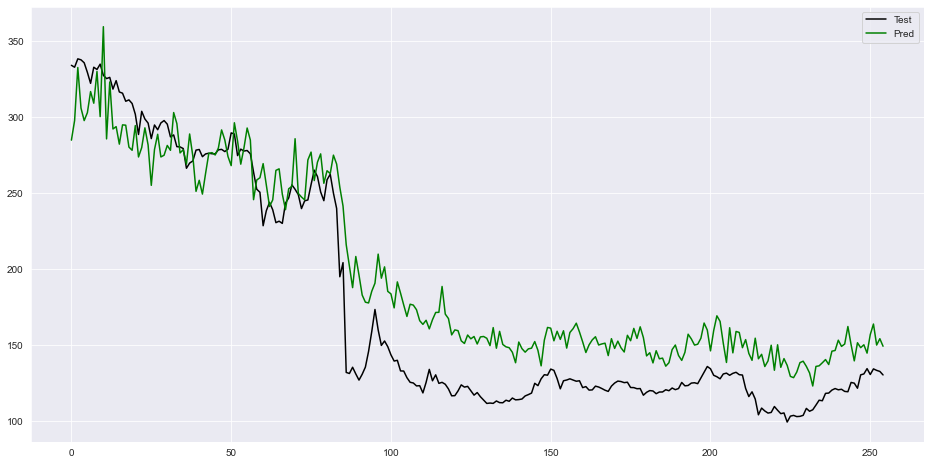

Val loss1 0.0532


In [66]:
actual_22, predicted_22, val_loss_22 = optimization_2.evaluate(val_dataloader, future=0)
df_actual_22, df_predicted_22, error22 = to_dataframe(sc, actual_22, predicted_22, data_set.columns[1:]) 
plt.figure(figsize=(16,8))
plt.plot(df_actual_22['CLOSE'], color='black', label='Test')
plt.plot(df_predicted_22['CLOSE'], color='green', label='Pred')
plt.legend()
plt.show()
print("Val loss1 %.4f" % val_loss_22)

Test: 100%|████████████████████████████████████████████████████████████████████████| 2036/2036 [00:31<00:00, 64.47it/s]


MSE: 43.1100, RMSE: 6.5658, MAE: 4.1867, f1: 0.4944, acc: 0.4907, recall: 0.4937


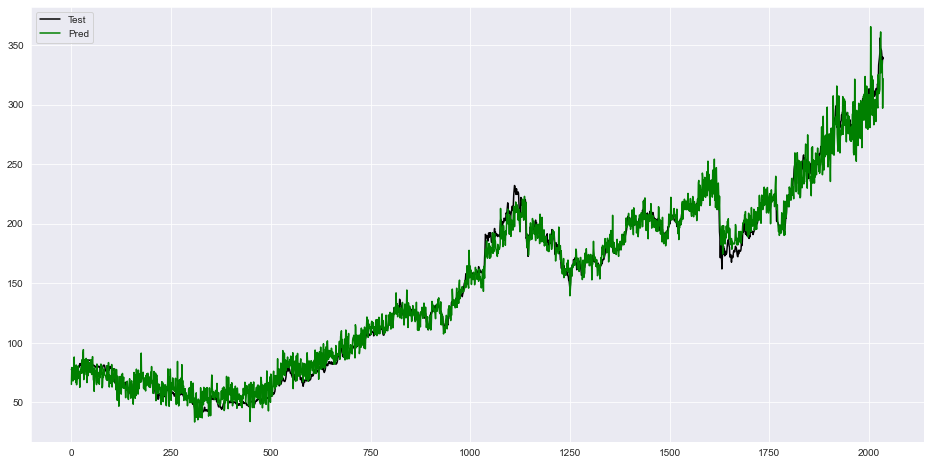

Train loss1 0.0085


In [67]:
actual_33, predicted_33, train_loss_33 = optimization_2.evaluate(train_dataloader1, future=0)
df_actual_33, df_predicted_33, error33 = to_dataframe(sc, actual_33, predicted_33, data_set.columns[1:]) 
plt.figure(figsize=(16,8))
plt.plot(df_actual_33['CLOSE'], color='black', label='Test')
plt.plot(df_predicted_33['CLOSE'], color='green', label='Pred')
plt.legend()
plt.show()
print("Train loss1 %.4f" % train_loss_33)

In [68]:
y_pred1 = generate_sequence(sc, optimization_2.model, x_sample1, future = future)

In [69]:
y_pred1 = pd.DataFrame(y_pred1)
y_pred1 = y_pred1.set_index(index)
y_pred1['Target'] = y_pred1[3] - y_pred1[3].shift()
y_pred1['TargetClass'] = [1 if y_pred1.Target[i] > 0 else 0 for i in range(len(y_pred1))]

In [70]:
mse1 = mean_squared_error(y_sample[3], y_pred1[3])
rmse1 = np.sqrt(mse)
mae1 = mean_absolute_error(y_sample[3], y_pred1[3])
f11 = metrics.f1_score(y_sample['TargetClass'][WINDOW_SIZE:], y_pred1['TargetClass'][WINDOW_SIZE:])
acc1 = metrics.accuracy_score(y_sample['TargetClass'][WINDOW_SIZE:], y_pred['TargetClass'][WINDOW_SIZE:])
recall1 = metrics.precision_score(y_sample['TargetClass'][WINDOW_SIZE:], y_pred['TargetClass'][WINDOW_SIZE:])
error_gen2 = {'MSE': mse1,'RMSE': rmse1,'MAE': mae1, 'f1': f11, 'acc': acc1, 'recall': recall1}
print('MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}, f1: {:.4f}, acc: {:.4f}, recall: {:.4f}'.format(mse1, rmse1, mae1, f11, acc1, recall1))

MSE: 6603.4176, RMSE: 82.8621, MAE: 71.1777, f1: 0.5646, acc: 0.4650, recall: 0.5204


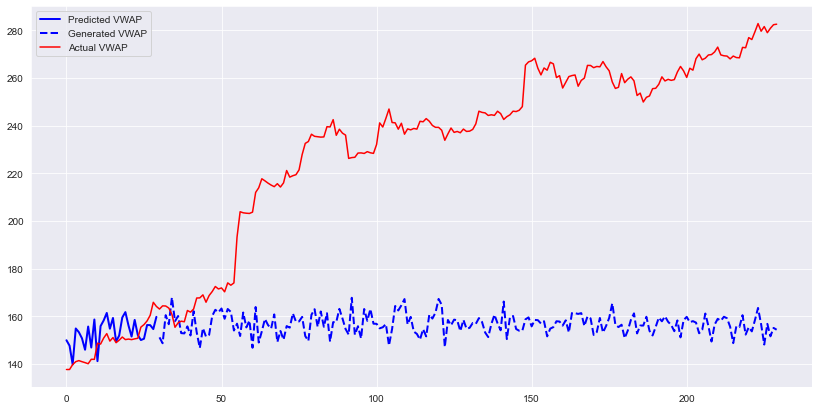

In [71]:
plt.figure(figsize=(14, 7))
plt.plot(range(WINDOW_SIZE), y_pred1[3][:WINDOW_SIZE], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(WINDOW_SIZE, future + WINDOW_SIZE), y_pred1[3][WINDOW_SIZE:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, future + WINDOW_SIZE), y_sample[3][:future + WINDOW_SIZE], color="red", label="Actual VWAP")
plt.legend()

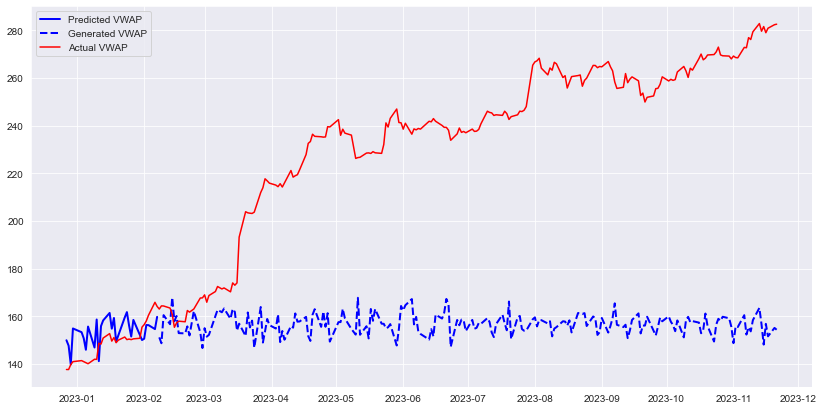

In [72]:
plt.figure(figsize=(14, 7))
plt.plot(y_pred1[3][:WINDOW_SIZE], color="blue", lw=2, label="Predicted VWAP")
plt.plot(y_pred1[3][WINDOW_SIZE:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(y_sample[3][:future + WINDOW_SIZE], color="red", label="Actual VWAP")
plt.legend()

In [95]:
error1['Loss'] = test_loss_1
error12['Loss'] = test_loss_15
error2['Loss'] = val_loss_2
error3['Loss'] = train_loss_3
error_gen1['Loss'] = np.nan
error11['Loss'] = test_loss_11
error112['Loss'] = test_loss_115
error22['Loss'] = val_loss_22
error33['Loss'] = train_loss_33
error_gen2['Loss'] = np.nan

In [96]:
er = [error1, error12, error2, error3, error_gen1, error11, error112, error22, error33, error_gen2]
ind = ['model_my_test', 'model_my_test5', 'model_my_val', 'model_my_train', 'model_my_gen', 'model_my1_test', 'model_my1_test5', 'model_my1_val', 'model_my1_train', 'model_my1_gen']
df_error = pd.DataFrame(er, index = ind)
df_error

,MSE,RMSE,MAE,f1,acc,recall,Loss
model_my_test,96.528164,9.824875,6.616127,0.496183,0.482353,0.507812,0.034077
model_my_test5,115.469689,10.745682,7.602304,0.493724,0.516000,0.495798,0.111952
model_my_val,314.881421,17.744898,11.815670,0.486957,0.537255,0.482759,0.033378
model_my_train,42.357063,6.508230,4.121760,0.513120,0.507859,0.510638,0.006332
model_my_gen,6866.130966,82.862120,72.777091,0.488038,0.465000,0.520408,NaN
model_my1_test,153.955927,12.407898,8.011390,0.436090,0.411765,0.439394,0.047529
model_my1_test5,160.170240,12.655838,8.617861,0.600000,0.584000,0.595420,0.113899
model_my1_val,442.859274,21.044222,14.025720,0.466102,0.505882,0.450820,0.053224
model_my1_train,43.110007,6.565821,4.186678,0.494393,0.490668,0.493671,0.008453
model_my1_gen,6603.417640,82.862120,71.177671,0.564593,0.465000,0.520408,NaN
